In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import to_categorical

train_data = pd.read_csv('../fake_news_data/train.csv')
train_data = train_data.set_index('id')
# train_data.head()

test_data = pd.read_csv('../fake_news_data/test.csv')
test_data = test_data.set_index('id')
# test_data.head()

submit = pd.read_csv('../fake_news_data/submit.csv')
submit = submit.set_index('id')
# submit.head()

# train_data['text'][0]

submit.info()
test_data.info()

from nltk.corpus import stopwords
import re

wnl = nltk.stem.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#remove null values from train_data
train_data = train_data.dropna()

#remove null values from test_data
test_data = test_data.join(submit)
test_data = test_data.dropna()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 20800 to 25999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   5200 non-null   int64
dtypes: int64(1)
memory usage: 81.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 20800 to 25999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5078 non-null   object
 1   author  4697 non-null   object
 2   text    5193 non-null   object
dtypes: object(3)
memory usage: 162.5+ KB


In [3]:

max_length = 1000
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, lower=True)

# train data
tokenizer.fit_on_texts(train_data['text'])
sequences = tokenizer.texts_to_sequences(train_data['text'])
train_sequence = pad_sequences(sequences, maxlen=max_length, value=0.0, padding='post')
# train_sequence = pad_sequences(sequences, value=0.0, padding='post')
# train_labels = np.asarray(train_data['label'])
train_labels = tf.keras.utils.to_categorical(train_data['label'], 2)
word_index = tokenizer.word_index

# test data
tokenizer.fit_on_texts(test_data['text'])
sequences = tokenizer.texts_to_sequences(test_data['text'])
test_sequence = pad_sequences(sequences, maxlen=max_length, value=0.0, padding='post')
# test_sequence = pad_sequences(sequences, value=0.0, padding='post')
# test_labels = np.asarray(test_data['label'])
# idx0 = 1 = fake
# idx1 = 0 = real
test_labels = tf.keras.utils.to_categorical(test_data['label'], 2)

x_train = train_sequence
y_train = train_labels
x_test = test_sequence
y_test = test_labels


# saving tokens
with open('../tokenizer/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
# Define the model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM, Dropout
  
model = Sequential()
# model.add(Embedding(num_words, 32, input_length=max_length))
model.add(Embedding(num_words, 32))
# model.add(Flatten())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [5]:
import os
glove_dir = '../data/glove.6B'
  
embeddings_index = {}
# use only one of 4 files from the glove vector set
with open(os.path.join(glove_dir, 'glove.6B.100d.txt'),'rt', encoding='UTF-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Found 400001 word vectors.


In [6]:
# Preparing the GloVe word embeddings matrix
# embedding matrix that we can load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in our reference word index (built during tokenization). Note that the index 0 isn’t supposed to stand for any word or token—it’s a placeholder.
embedding_dim = 100
  
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < num_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
len(embedding_matrix)

10000

In [7]:
# Define the model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM, Dropout

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
# model.add(Embedding(num_words, 32, input_length=max_length))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 flatten (Flatten)           (None, 100000)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                6400064   
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 7,400,194
Trainable params: 7,400,194
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
              epochs=5,
              batch_size=30,
              shuffle=True,
              validation_split=0.1,
              # callbacks=[early_stop]
              )

Epoch 1/5
549/549 [==============================] - 12s 21ms/step - loss: 0.4801 - accuracy: 0.7719 - val_loss: 0.3834 - val_accuracy: 0.8464
Epoch 2/5
549/549 [==============================] - 11s 21ms/step - loss: 0.2219 - accuracy: 0.9324 - val_loss: 0.3395 - val_accuracy: 0.8513
Epoch 3/5
549/549 [==============================] - 11s 20ms/step - loss: 0.0990 - accuracy: 0.9865 - val_loss: 0.3508 - val_accuracy: 0.8502
Epoch 4/5
549/549 [==============================] - 11s 21ms/step - loss: 0.0440 - accuracy: 0.9984 - val_loss: 0.3692 - val_accuracy: 0.8464
Epoch 5/5
549/549 [==============================] - 11s 20ms/step - loss: 0.0221 - accuracy: 0.9995 - val_loss: 0.3666 - val_accuracy: 0.8557


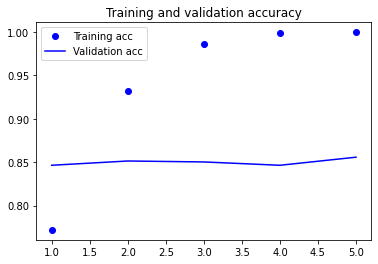

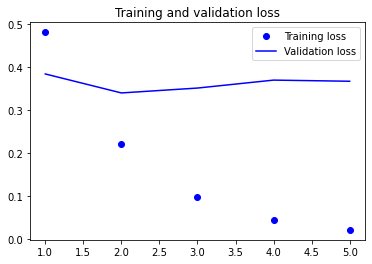

In [9]:
# Plot performance over time
import matplotlib.pyplot as plt
  
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
model.evaluate(x_test,y_test) # to beat 71%

143/143 [==============================] - 1s 7ms/step - loss: 0.7072 - accuracy: 0.7187


[0.707158625125885, 0.7186885476112366]

In [11]:
model.save('../saved_models')

INFO:tensorflow:Assets written to: ../saved_models\assets


In [12]:
loaded_model = tf.keras.models.load_model('../saved_models')
loaded_model.evaluate(x_test,y_test)

143/143 [==============================] - 1s 8ms/step - loss: 0.7072 - accuracy: 0.7187


[0.707158625125885, 0.7186885476112366]